In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [2]:
pattern = r"""reading_speed=([^\s]+) B/s,parsing_speed=([^\s]+) B/s,size=([^\s]+) B,reading_milliseconds=([^,]+),parsing_milliseconds=([^,]+),PID=3992837,SLURM_JOB_ID=691720
Code block 'i=(\d+), fname='/scratch/shared/pwesolowski/mgr-pipeline/joined-cuml/([^.]+).json', count=\d+, force_host_read=([^,]+), pinned_read=([^,]+), cufile_params=(None|'cufile_thread_count=(\d+), cufile_slice_size_mb=(\d+)')' took: ([^\s]+) ms"""

In [3]:
with open("slurm-691720.out") as f:
    logs = f.read()

In [4]:
measurements = []

for match in re.findall(pattern, logs, re.M):
    # We remove first "warmup" observation
    if (rep := int(match[5])) > 0:
        measurements.append({
            "reading_speed (GiB/sec)": float(match[0]) / 1024 / 1024 / 1024,
            "parsing_speed (GiB/sec)": float(match[1]) / 1024 / 1024 / 1024,
            "file_size (GiB)": float(match[2]) / 1024 / 1024 / 1024,
            "rep": rep,
            "file": match[6],
            "force_host_read": True if match[7] == "True" else False,
            "pinned_read": True if match[8] == "True" else False if match[8] == "False" else None,
            "cufile_thread_count": int(match[10]) if match[10] else None,
            "cufile_slice_size_mb": int(match[11]) if match[11] else None,
            "took (msecs)": float(match[12])
        })
measurements_df = pd.DataFrame(measurements)

In [5]:
!ls

benchmark.py		     dask-submission.sbatch  slurm-693520.out
cufile.json		     img		     submission.sbatch
dask_benchmark.py	     results-analysis.ipynb
dask-results-analysis.ipynb  slurm-691720.out


In [6]:
measurements_df.rename(columns={"took (msecs)": "time (msecs)"}, inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


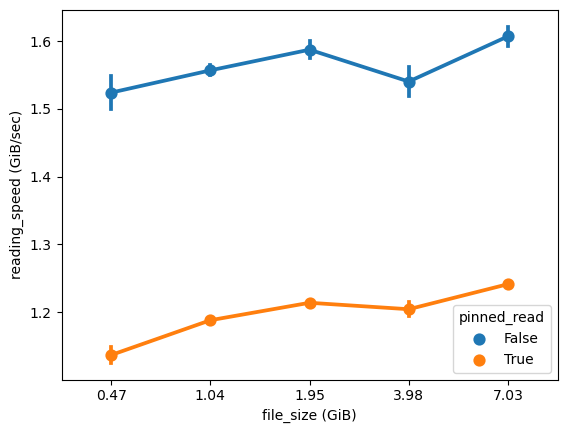

In [7]:
g = sns.pointplot(
    data=measurements_df[measurements_df["force_host_read"]],
    x="file_size (GiB)",
    y="reading_speed (GiB/sec)",
    hue="pinned_read",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/pinned-read-reading-speed.eps", format="eps", bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


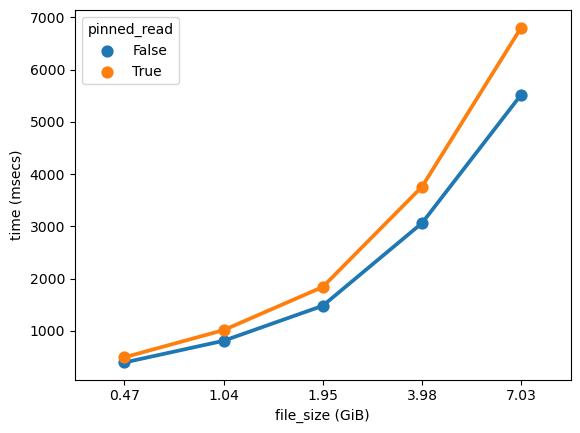

In [8]:
g = sns.pointplot(
    data=measurements_df[measurements_df["force_host_read"]],
    x="file_size (GiB)",
    y="time (msecs)",
    hue="pinned_read",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/pinned-read-took.eps", format="eps", bbox_inches='tight')
plt.show()

Stąd decyzja, że odtąd używamy pinned_read = False

Uwaga! W eksperymentach ponizej wyszlo, ze cufile_slice_size_mb nie mial za duzego znaczenia (praktycznie zadne, wszystkie wykresy wygladaly z grubsza tak samo). Stąd zostajemy przy cufile_slice_size_mb = 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


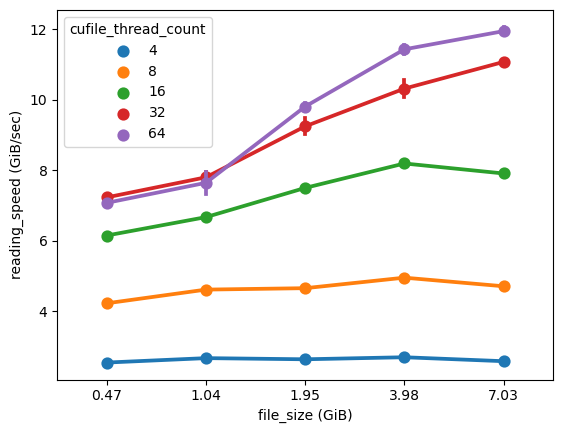

In [9]:
gds_df = measurements_df[
    (~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1)
]
g = sns.pointplot(
    data=gds_df,
    x="file_size (GiB)",
    y="reading_speed (GiB/sec)",
    hue=gds_df["cufile_thread_count"].astype(int),
    palette=sns.color_palette(n_colors=gds_df["cufile_thread_count"].nunique()),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/gds-reading-speed.eps", format="eps", bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


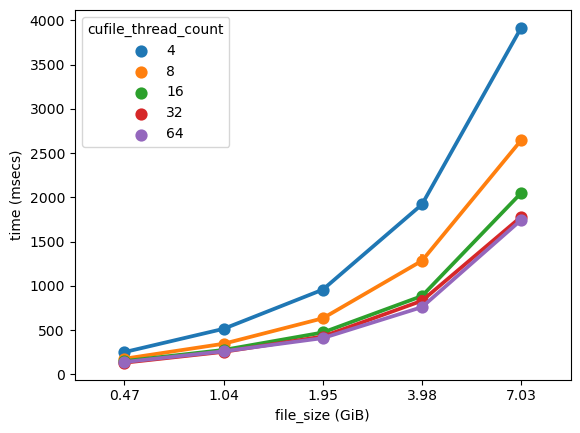

In [10]:
gds_df = measurements_df[
    (~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1)
]
g = sns.pointplot(
    data=gds_df,
    x="file_size (GiB)",
    y="time (msecs)",
    hue=gds_df["cufile_thread_count"].astype(int),
    palette=sns.color_palette(n_colors=gds_df["cufile_thread_count"].nunique()),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/gds-took.eps", format="eps", bbox_inches='tight')
plt.show()

## Comparison between GDS and non-GDS:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


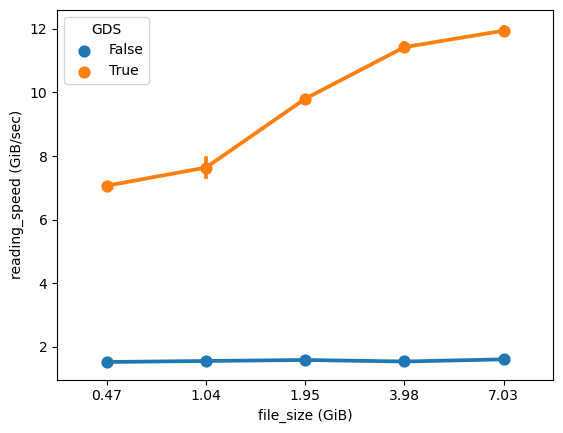

In [11]:
comparison_df = measurements_df.copy()[
    ((measurements_df["force_host_read"]) & (~(measurements_df["pinned_read"].fillna(False)))) |
    ((~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1) & (measurements_df["cufile_thread_count"] == 64))
]
comparison_df["GDS"] = ~comparison_df["force_host_read"]
g = sns.pointplot(
    data=comparison_df,
    x="file_size (GiB)",
    y="reading_speed (GiB/sec)",
    hue="GDS",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/comparison-reading-speed.eps", format="eps", bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


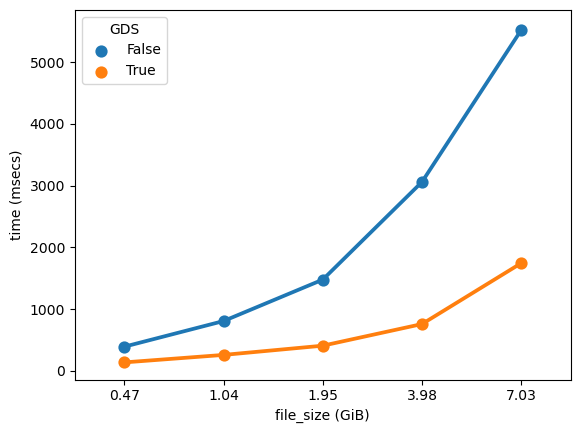

In [12]:
comparison_df = measurements_df.copy()[
    ((measurements_df["force_host_read"]) & (~(measurements_df["pinned_read"].fillna(False)))) |
    ((~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1) & (measurements_df["cufile_thread_count"] == 64))
]
comparison_df["GDS"] = ~comparison_df["force_host_read"]
g = sns.pointplot(
    data=comparison_df,
    x="file_size (GiB)",
    y="time (msecs)",
    hue="GDS",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/comparison-took.eps", format="eps", bbox_inches='tight')
plt.show()